In [1]:
import seaborn as sns
from scipy.stats import skew, kurtosis, spearmanr, pearsonr
from enformer_pytorch import Enformer
import torch
import time
import numpy as np
from pyfaidx import Fasta
import glob
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import os
import shutil
warnings.filterwarnings("ignore")


founders = ['A_J.39',         'C57BL_6J.39',
            '129S1_SvImJ.39', 'NOD_ShiLtJ.39',
            'NZO_HlLtJ.39',   'CAST_EiJ.39',
            'PWK_PhJ.39',     'WSB_EiJ.39']



## load enformer results
df = pd.read_csv("/projects/compsci/vmp/USERS/chenm/mahoney/enformer/results_0/df_enformer_results_combined.csv")
print(df.shape)

/home/chenm/.local/lib/python3.7/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.16) or chardet (5.2.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


(257290, 1646)


# Get track index for "AGE/liver, adult pregnant day01

In [2]:
xls_file = pd.ExcelFile('/projects/compsci/vmp/USERS/chenm/mahoney/41592_2021_1252_MOESM3_ESM.xlsx')
table3 = pd.read_excel(xls_file, 'Supplementary Table 3')
idx_liver = int(table3[table3["target"] == "CAGE/liver, adult pregnant day01"]["index"].values[0])
print("index for CAGE/liver, adult pregnant day01: ", idx_liver)

index for CAGE/liver, adult pregnant day01:  1288


In [3]:
def prepare_data(df, idx, coef_file, cutoff=0):
    df1 = df[["gene_id", "strain", str(idx)]]
    df1 = df1.pivot(index='gene_id', columns='strain', values=str(idx))
    df1 = df1.rename_axis(None, axis=1)
    df1.index.name = None
    df1 = df1[founders]
    df1 = df1[df1.mean(axis = 1)>cutoff] 
    # load QTL allele effects   
    c2eff = pd.read_csv(coef_file, index_col=0)
    c2eff.index.name = None
    
    # subset common genes 
    df1 = df1.dropna()
    gene_list = list(set(df1.index) & set(c2eff.index))
    print(len(gene_list))
    df1 = df1.loc[gene_list]     
    c2eff = c2eff.loc[gene_list]
    print("df1 shape: ", df1.shape)
    print("c2eff shape: ", c2eff.shape)
    return df1, c2eff

coef_file = "/projects/compsci/vmp/USERS/chenm/mahoney/enformer/qtlcoef_liver_CUBE.csv"
df1, c2eff = prepare_data(df, idx_liver, coef_file)

17190
df1 shape:  (17190, 8)
c2eff shape:  (17190, 9)


In [4]:
df1.head()

,A_J.39,C57BL_6J.39,129S1_SvImJ.39,NOD_ShiLtJ.39,NZO_HlLtJ.39,CAST_EiJ.39,PWK_PhJ.39,WSB_EiJ.39
ENSMUSG00000057278,1.292690,1.182701,1.283203,1.208547,1.184866,1.856467,1.405898,1.166856
ENSMUSG00000091586,0.030055,0.030795,0.030559,0.029985,0.031223,0.085458,0.025183,0.029013
ENSMUSG00000022999,0.070869,0.071095,0.070272,0.070735,0.070722,0.067242,0.070901,0.071716
ENSMUSG00000022304,0.006668,0.006668,0.007665,0.006213,0.006663,0.006733,0.007515,0.006813
ENSMUSG00000025823,7.848420,11.520156,11.358971,11.663200,11.503024,5.893571,0.502272,12.436699


In [5]:
c2eff["pred_mean"] = df1.mean(axis=1)
c2eff.head()

,lod,A_J.39,C57BL_6J.39,129S1_SvImJ.39,NOD_ShiLtJ.39,NZO_HlLtJ.39,CAST_EiJ.39,PWK_PhJ.39,WSB_EiJ.39,pred_mean
ENSMUSG00000057278,2.481606,0.088483,-0.018186,-0.054794,0.022932,-0.093380,0.009071,0.139977,-0.094103,1.322653
ENSMUSG00000091586,84.424636,-0.264761,-0.181317,-0.445601,0.363353,-0.213154,0.258827,0.946233,-0.463580,0.036534
ENSMUSG00000022999,4.679183,0.011920,-0.018652,0.158032,-0.026452,-0.098448,0.000563,-0.063783,0.036820,0.070444
ENSMUSG00000022304,45.257468,-0.136526,-0.174572,0.583571,0.149943,-0.200445,0.010893,-0.374943,0.142079,0.006867
ENSMUSG00000025823,2.714521,0.011669,0.090193,0.039326,0.085025,0.065891,-0.049554,-0.218982,-0.023569,9.090789


Skew (spearman corr):  -0.07645113674395433
Kurtosis (spearman corr):  -0.8072265857091563
Skew (pearson corr):  -0.10564642618108758
Kurtosis (pearson corr):  -1.0325869826041905


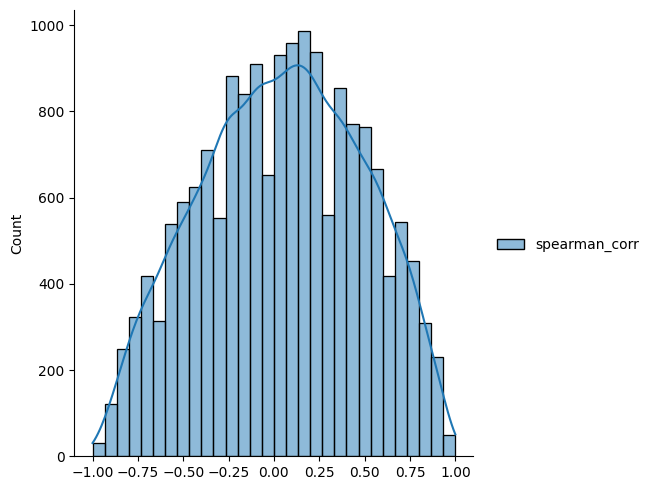

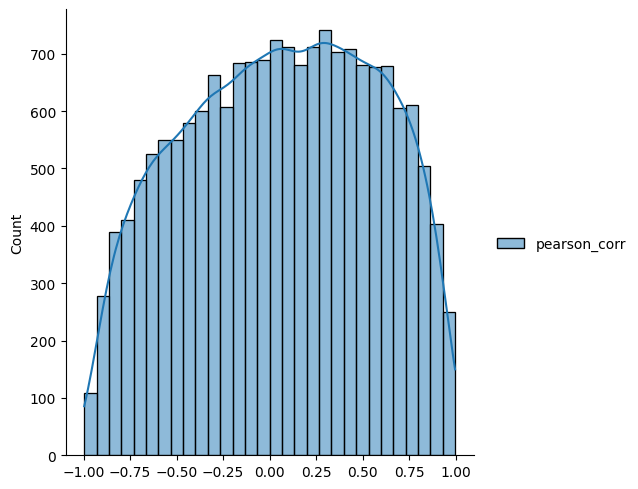

In [6]:
def cal_corrcoefs(df1, c2eff, strains):
    spearman_corr = df1[strains].corrwith(other=c2eff[strains], method="spearman",  axis=1)
    spearman_corr = pd.DataFrame(spearman_corr, columns=["spearman_corr"])

    print("Skew (spearman corr): ", skew(spearman_corr.spearman_corr, axis=0, bias=True))
    print("Kurtosis (spearman corr): ", kurtosis(spearman_corr.spearman_corr, axis=0, bias=True))

    pearson_corr = df1[strains].corrwith(other=c2eff[strains], method="pearson",  axis=1)
    pearson_corr = pd.DataFrame(pearson_corr, columns=["pearson_corr"])
    sns.displot(spearman_corr, kde=True, bins=30) #.set(title='Spearman Corrcoef Distribution')
    sns.displot(pearson_corr, kde=True, bins=30)#.set(title='Pearson Corrcoef Distribution')
    
    
    skew_pearson = skew(pearson_corr.pearson_corr, axis=0, bias=True)
    skew_spearman = skew(spearman_corr.spearman_corr, axis=0, bias=True)
    print("Skew (pearson corr): ", skew_pearson)
    print("Kurtosis (pearson corr): ", kurtosis(pearson_corr.pearson_corr, axis=0, bias=True))
    return spearman_corr, pearson_corr, skew_spearman, skew_pearson

spearman_corr, pearson_corr, skew_spearman, skew_pearson = cal_corrcoefs(df1, c2eff, founders)


In [7]:
pearson_corr.head()

,pearson_corr
ENSMUSG00000057278,0.322887
ENSMUSG00000091586,0.141670
ENSMUSG00000022999,-0.073273
ENSMUSG00000022304,0.218507
ENSMUSG00000025823,0.892401


In [9]:
c2eff["pearson_corr"] = pearson_corr
c2eff["spearman_corr"] = spearman_corr
c2eff_copy = c2eff.copy()
#c2eff.to_csv('/projects/compsci/vmp/USERS/chenm/mahoney/enformer/coef_liver_CUBE.csv')
c2eff.head()

,lod,A_J.39,C57BL_6J.39,129S1_SvImJ.39,NOD_ShiLtJ.39,NZO_HlLtJ.39,CAST_EiJ.39,PWK_PhJ.39,WSB_EiJ.39,pred_mean,pearson_corr,spearman_corr
ENSMUSG00000057278,2.481606,0.088483,-0.018186,-0.054794,0.022932,-0.093380,0.009071,0.139977,-0.094103,1.322653,0.322887,0.714286
ENSMUSG00000091586,84.424636,-0.264761,-0.181317,-0.445601,0.363353,-0.213154,0.258827,0.946233,-0.463580,0.036534,0.141670,-0.071429
ENSMUSG00000022999,4.679183,0.011920,-0.018652,0.158032,-0.026452,-0.098448,0.000563,-0.063783,0.036820,0.070444,-0.073273,0.000000
ENSMUSG00000022304,45.257468,-0.136526,-0.174572,0.583571,0.149943,-0.200445,0.010893,-0.374943,0.142079,0.006867,0.218507,0.131739
ENSMUSG00000025823,2.714521,0.011669,0.090193,0.039326,0.085025,0.065891,-0.049554,-0.218982,-0.023569,9.090789,0.892401,0.619048


Text(0.5, 0, 'spearman_corr')

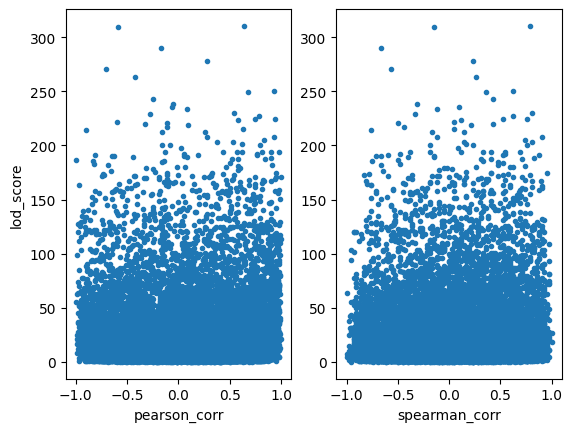

In [58]:
c2eff = c2eff_copy.copy()
fig, ax = plt.subplots(1,2)
ax[0].plot(c2eff["pearson_corr"], c2eff["lod"], ".")
ax[0].set_xlabel("pearson_corr")
ax[0].set_ylabel("lod_score")
ax[1].plot(c2eff["spearman_corr"], c2eff["lod"], ".")
ax[1].set_xlabel("spearman_corr")

# Prepare inputs

(17190, 12)


array([[<AxesSubplot:title={'center':'lod'}>,
        <AxesSubplot:title={'center':'pred_mean'}>,
        <AxesSubplot:title={'center':'A_J.39'}>],
       [<AxesSubplot:title={'center':'129S1_SvImJ.39'}>,
        <AxesSubplot:title={'center':'NOD_ShiLtJ.39'}>,
        <AxesSubplot:title={'center':'NZO_HlLtJ.39'}>],
       [<AxesSubplot:title={'center':'CAST_EiJ.39'}>,
        <AxesSubplot:title={'center':'PWK_PhJ.39'}>,
        <AxesSubplot:title={'center':'WSB_EiJ.39'}>]], dtype=object)

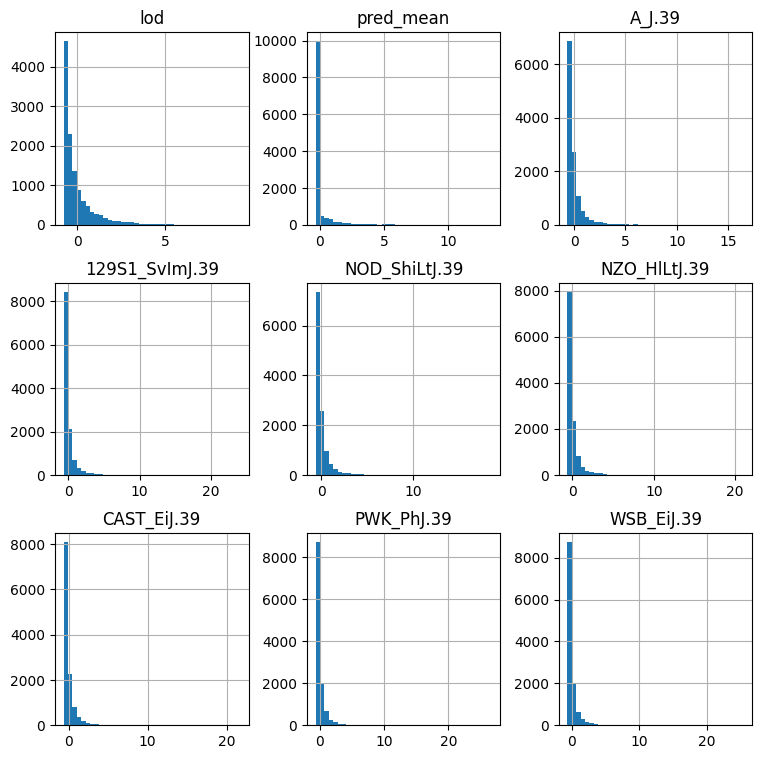

In [86]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

c2eff = c2eff_copy
print(c2eff.shape)
cols = ['lod', 'pred_mean', 'A_J.39',  '129S1_SvImJ.39',
       'NOD_ShiLtJ.39', 'NZO_HlLtJ.39', 'CAST_EiJ.39', 'PWK_PhJ.39',
       'WSB_EiJ.39']


X = abs(c2eff[cols])
y = abs(c2eff['pearson_corr'])
#y = c2eff['spearman_corr']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)


sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols)
%matplotlib inline
X_train_scaled.hist(bins=40,figsize=(9, 9))

--------------- Correlation Matrix ---------------


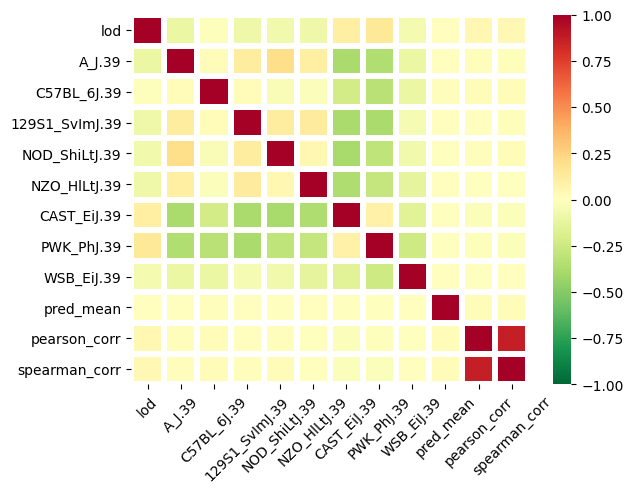

In [87]:
corr_df = c2eff.corr()
%matplotlib inline
import seaborn
import matplotlib.pyplot as plt
print("--------------- Correlation Matrix ---------------")
seaborn.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1 , linewidths=3,fmt='.1f')
# Show the plot we reorient the labels for each column and row to make them easier to read.
plt.yticks(rotation=0,fontsize=10) 
plt.xticks(rotation=45,fontsize=10) 
plt.show()

# Linear Regression

Linear Regression Training R-sqaure:  0.017956667035048057
Linear Regression Test R-sqaure:  0.016590272920029014


,Feature,Importance
5,NZO_HlLtJ.39,-0.009812
8,WSB_EiJ.39,-0.007758
2,A_J.39,-0.007056
3,129S1_SvImJ.39,-0.004378
4,NOD_ShiLtJ.39,0.000902
1,pred_mean,0.006082
6,CAST_EiJ.39,0.018084
7,PWK_PhJ.39,0.019175
0,lod,0.021730


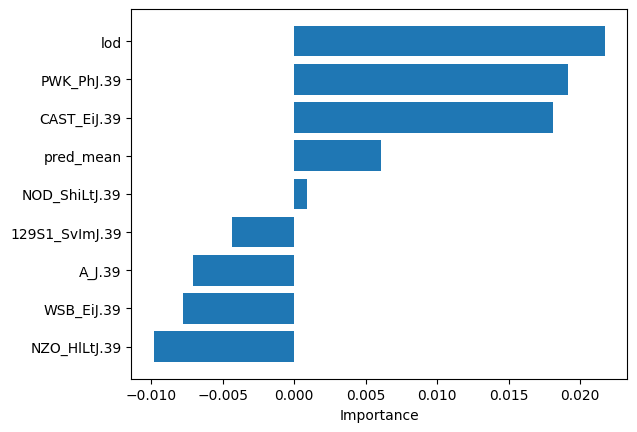

In [88]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
coefficients = model.coef_

# r_sq = model.score(X_train_std, y_train)
# print(f"R_square: {r_sq}")
# print(f"Intercept: {model.intercept_}")  

r_sq = model.score(X_train_scaled,y_train)
print( 'Linear Regression Training R-sqaure: ', r_sq)

r_sq = model.score(X_test_scaled,y_test)
print( 'Linear Regression Test R-sqaure: ', r_sq)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance')

plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
feature_importance

# Random Forest Regression

In [89]:
#Hyperparameter tuning 
from sklearn.model_selection import RandomizedSearchCV
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    print('Model Performance')
    print('Mean Absolute Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('R_square = {:0.2f}'.format(model.score(test_features, test_labels)))
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 4)]
# Number of features to consider at every split
max_features = ['sqrt']#'auto', 
# Maximum number of levels in tree
max_depth = [2,4,6,8,10]
# Minimum number of samples required to split a node
min_samples_split = [2, 4, 6, 8, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4, 6, 8]
# Method of selecting samples for training each tree
bootstrap = [True]#, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)



{'n_estimators': [50, 100, 150, 200], 'max_features': ['sqrt'], 'max_depth': [2, 4, 6, 8, 10], 'min_samples_split': [2, 4, 6, 8, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True]}


In [76]:
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(X_train_scaled, y_train)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 50,
 'min_samples_split': 4,
 'min_samples_leaf': 8,
 'max_features': 'sqrt',
 'max_depth': 6,
 'bootstrap': True}

Random Forest Regression Training R-square:  0.0860365952433495
Random Forest Regression Test R-square:  0.0359341315665519


,Feature,Importance
5,NZO_HlLtJ.39,0.053392
3,129S1_SvImJ.39,0.056928
8,WSB_EiJ.39,0.062970
4,NOD_ShiLtJ.39,0.071173
2,A_J.39,0.075939
1,pred_mean,0.082563
6,CAST_EiJ.39,0.169478
7,PWK_PhJ.39,0.175961
0,lod,0.251598


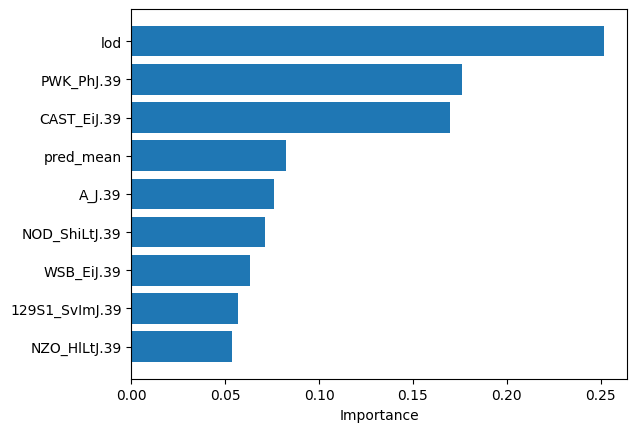

In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

rf = RandomForestRegressor(**rf_random.best_params_)
rf.fit(X_train_scaled, y_train)
score = rf.score(X_train_scaled, y_train)
print( 'Random Forest Regression Training R-square: ', score)
score =  rf.score(X_test_scaled, y_test)
print( 'Random Forest Regression Test R-square: ', score)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance')
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
feature_importance

# Choose high log score (lod > 6)


In [95]:
c2eff = c2eff_copy[c2eff_copy["lod"]>6]
print(c2eff.shape)
cols = ['lod', 'pred_mean', 'A_J.39',  '129S1_SvImJ.39',
       'NOD_ShiLtJ.39', 'NZO_HlLtJ.39', 'CAST_EiJ.39', 'PWK_PhJ.39',
       'WSB_EiJ.39']


X = abs(c2eff[cols])
y = abs(c2eff['pearson_corr'])
#y = c2eff['spearman_corr']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=1)


sc = StandardScaler()
sc.fit(X_train)

X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=cols)


(11788, 12)


Linear Regression Training R-sqaure:  0.008455945493144545
Linear Regression Test R-sqaure:  0.011416628201130097


,Feature,Importance
8,WSB_EiJ.39,-0.012075
5,NZO_HlLtJ.39,-0.007358
2,A_J.39,-0.005848
3,129S1_SvImJ.39,-0.004293
4,NOD_ShiLtJ.39,-0.000586
1,pred_mean,0.005541
6,CAST_EiJ.39,0.014106
0,lod,0.014521
7,PWK_PhJ.39,0.015926


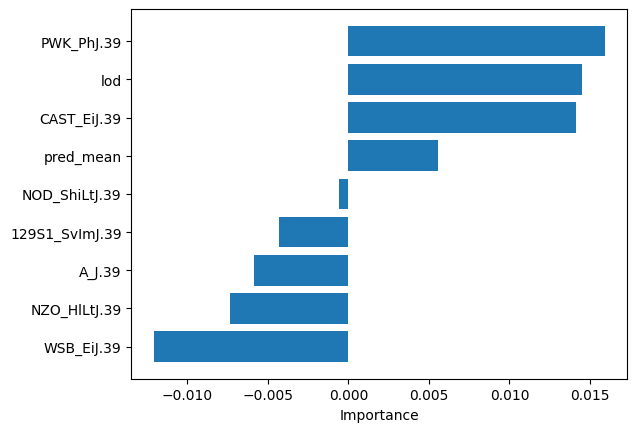

In [92]:
#linear regression
model = LinearRegression()
model.fit(X_train_scaled, y_train)
coefficients = model.coef_

# r_sq = model.score(X_train_std, y_train)
# print(f"R_square: {r_sq}")
# print(f"Intercept: {model.intercept_}")  

r_sq = model.score(X_train_scaled,y_train)
print( 'Linear Regression Training R-sqaure: ', r_sq)

r_sq = model.score(X_test_scaled,y_test)
print( 'Linear Regression Test R-sqaure: ', r_sq)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': coefficients})
feature_importance = feature_importance.sort_values('Importance')

plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
feature_importance

Random Forest Regression Training R-square:  0.06978331665786819
Random Forest Regression Test R-square:  0.014500858394748684


,Feature,Importance
5,NZO_HlLtJ.39,0.076584
3,129S1_SvImJ.39,0.085555
2,A_J.39,0.090519
0,lod,0.105054
1,pred_mean,0.105848
8,WSB_EiJ.39,0.108984
4,NOD_ShiLtJ.39,0.113587
6,CAST_EiJ.39,0.138851
7,PWK_PhJ.39,0.175019


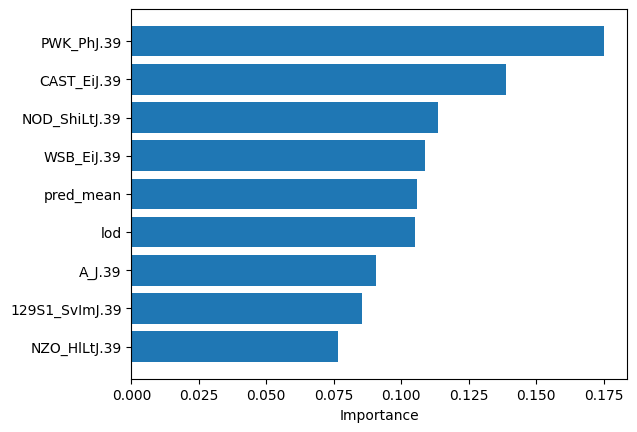

In [93]:
## random forest
rf = RandomForestRegressor(**rf_random.best_params_)
rf.fit(X_train_scaled, y_train)
score = rf.score(X_train_scaled, y_train)
print( 'Random Forest Regression Training R-square: ', score)
score =  rf.score(X_test_scaled, y_test)
print( 'Random Forest Regression Test R-square: ', score)

feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': rf.feature_importances_})
feature_importance = feature_importance.sort_values('Importance')
plt.barh(feature_importance["Feature"], feature_importance["Importance"])
plt.xlabel("Importance")
feature_importance